# Шаг 1. Загрузка обученной модели и данных MNIST

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images[:1000]
test_labels = test_labels[:1000]

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в категориальный формат
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных (тестовых) данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9814 - loss: 0.0560
Test accuracy on clean images: 0.9779999852180481


# Шаг 2. Реализация атаки Carlini-Wagne

In [4]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.6 MB/s eta 0:00:00


tf.Tensor(4, shape=(), dtype=int64)


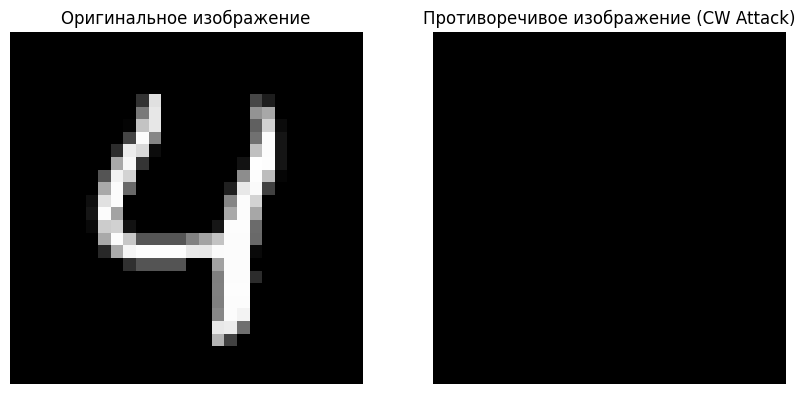

In [7]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))
image = tf.convert_to_tensor(test_images[4], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[4])
label = tf.convert_to_tensor(label, dtype=tf.int64)
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
print(label)

advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

# Шаг 3. Оценка модели на противоричивых примерах

In [20]:
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)

print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0786 - loss: 2.2659
Accuracy on adversarial examples (CW attack): 0.07100000232458115
